In [ ]:
#install Kaggle
!pip install -q kaggle

In [ ]:
#upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"savelii","key":"9c5ca65540ae867ae75fb60770223572"}'}

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d spandan2/cats-faces-64x64-for-generative-models
!unzip /content/cats-faces-64x64-for-generative-models.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: cats/cats/5499.jpg      
  inflating: cats/cats/55.jpg        
  inflating: cats/cats/550.jpg       
  inflating: cats/cats/5500.jpg      
  inflating: cats/cats/5501.jpg      
  inflating: cats/cats/5502.jpg      
  inflating: cats/cats/5503.jpg      
  inflating: cats/cats/5504.jpg      
  inflating: cats/cats/5505.jpg      
  inflating: cats/cats/5506.jpg      
  inflating: cats/cats/5507.jpg      
  inflating: cats/cats/5508.jpg      
  inflating: cats/cats/5509.jpg      
  inflating: cats/cats/551.jpg       
  inflating: cats/cats/5510.jpg      
  inflating: cats/cats/5511.jpg      
  inflating: cats/cats/5512.jpg      
  inflating: cats/cats/5513.jpg      
  inflating: cats/cats/5514.jpg      
  inflating: cats/cats/5515.jpg      
  inflating: cats/cats/5516.jpg      
  inflating: cats/cats/5517.jpg      
  inflating: cats/cats/5518.jpg      
  inflating: cats/cats/5519.jpg      
  inflating: cats/ca

In [ ]:
import numpy as np # linear algebra
import pandas as pd

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
from torch import device
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
import torch.nn.functional as F
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [ ]:
direc= '/content/cats'

In [ ]:
print(os.listdir(direc+ '/cats')[:5])


['15290.jpg', '3212.jpg', '4624.jpg', '14680.jpg', '10160.jpg']


The data is normalized to mean=0 and SD= 0.5 so as to fit the data in (-1,1) range. This is useful for generator as it uses tanh function in the last layer. Apart from that, image size is reduced to 64x64 considering the computational cost. 

In [ ]:
image_size = 64
batch_size = 128
latent_size= 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train = ImageFolder(direc, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))
 
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=3, pin_memory=True) #For loading data into batches

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())
    # out: 3 x 64 x 64


In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
#To save the samples produced during epochs

sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors).to(device)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

### тренируем дискриминатор

In [ ]:
def train_discriminator(real_images, opt_d):
    
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images).to(device) #real images
    real_targets = torch.ones(real_images.size(0), 1).to(device) #setting targets as 1
    real_loss = F.binary_cross_entropy(real_preds, real_targets) #getting the loss
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1).to(device) #generating the random noices for input image
    fake_images = generator(latent).to(device)  #getting the fake images

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1).to(device) #setting 0 as target for fake images
    fake_preds = discriminator(fake_images).to(device)  #getting the predictions for fake images
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)  #Comparing the two scores through loss
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

### Тренируем генератор

In [ ]:
def train_generator(opt_g):
    
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1,1).to(device) #random noice
    fake_images = generator(latent).to(device) #fake images generated
    
    # Try to fool the discriminator
    preds = discriminator(fake_images).to(device) #getting the predictions of discriminator for fake images
    targets = torch.ones(batch_size, 1).to(device) #setting 1 as targets so the discriminator can be fooled
    loss = F.binary_cross_entropy(preds, targets) #comparing
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item(),latent

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.to(device).parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.to(device).parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            
            # Train discriminator
            real_images= real_images.to(device)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            
            # Train generator
            loss_g, latent = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {}, loss_d: {}, real_score: {}, fake_score: {}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, latent, show=False)
    
    return losses_g, losses_d, latent, fake_scores

In [ ]:
model = fit(epochs=100, lr=0.0002) #set epochs to 40 or more for better results

  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 5.566094875335693, loss_d: 0.1330784410238266, real_score: 0.914461612701416, fake_score: 0.040007028728723526
Saving generated-images-0001.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 2.9353694915771484, loss_d: 0.7310439348220825, real_score: 0.7031502723693848, fake_score: 0.2093559056520462
Saving generated-images-0002.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 2.492811679840088, loss_d: 0.8186032772064209, real_score: 0.481126993894577, fake_score: 0.017983250319957733
Saving generated-images-0003.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 4.576021194458008, loss_d: 0.36764106154441833, real_score: 0.8673493266105652, fake_score: 0.17657290399074554
Saving generated-images-0004.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 3.235428810119629, loss_d: 0.4346228241920471, real_score: 0.7249593734741211, fake_score: 0.08114892989397049
Saving generated-images-0005.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 2.8216640949249268, loss_d: 0.6875928640365601, real_score: 0.7453423738479614, fake_score: 0.22851905226707458
Saving generated-images-0006.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 4.208096504211426, loss_d: 0.30125921964645386, real_score: 0.8643292784690857, fake_score: 0.13042667508125305
Saving generated-images-0007.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 5.459664344787598, loss_d: 0.2896463871002197, real_score: 0.9180704355239868, fake_score: 0.16233673691749573
Saving generated-images-0008.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 0.2263437807559967, loss_d: 1.5425753593444824, real_score: 0.25491660833358765, fake_score: 0.06937645375728607
Saving generated-images-0009.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.2709171772003174, loss_d: 1.2241239547729492, real_score: 0.5373682379722595, fake_score: 0.29404038190841675
Saving generated-images-0010.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 1.2656515836715698, loss_d: 1.0311484336853027, real_score: 0.415860116481781, fake_score: 0.09010199457406998
Saving generated-images-0011.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 1.224825143814087, loss_d: 0.6316736340522766, real_score: 0.6929352283477783, fake_score: 0.052309103310108185
Saving generated-images-0012.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 5.407077789306641, loss_d: 0.32261791825294495, real_score: 0.9831593036651611, fake_score: 0.2388748824596405
Saving generated-images-0013.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 4.507767677307129, loss_d: 0.22660544514656067, real_score: 0.835941731929779, fake_score: 0.04050064831972122
Saving generated-images-0014.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.2451856136322021, loss_d: 1.1929903030395508, real_score: 0.49826884269714355, fake_score: 0.09130944311618805
Saving generated-images-0015.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 5.352044105529785, loss_d: 0.2079669088125229, real_score: 0.8264119029045105, fake_score: 0.015218071639537811
Saving generated-images-0016.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 7.140279769897461, loss_d: 0.3534221351146698, real_score: 0.988146185874939, fake_score: 0.2425975799560547
Saving generated-images-0017.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 3.3656182289123535, loss_d: 0.336107075214386, real_score: 0.7320297956466675, fake_score: 0.02123168297111988
Saving generated-images-0018.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 3.5276360511779785, loss_d: 0.38308778405189514, real_score: 0.9149173498153687, fake_score: 0.2050001621246338
Saving generated-images-0019.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 1.1797475814819336, loss_d: 0.6364045739173889, real_score: 0.6596404314041138, fake_score: 0.1291898936033249
Saving generated-images-0020.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 3.9663004875183105, loss_d: 0.4681692123413086, real_score: 0.7965723276138306, fake_score: 0.1678863912820816
Saving generated-images-0021.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.767429351806641, loss_d: 0.12695203721523285, real_score: 0.9002422094345093, fake_score: 0.014804473146796227
Saving generated-images-0022.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 4.874848365783691, loss_d: 0.09426872432231903, real_score: 0.9656827449798584, fake_score: 0.055197928100824356
Saving generated-images-0023.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 4.946303367614746, loss_d: 0.13740992546081543, real_score: 0.9628741145133972, fake_score: 0.08747990429401398
Saving generated-images-0024.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 1.4507570266723633, loss_d: 0.589964747428894, real_score: 0.6585487723350525, fake_score: 0.08364991843700409
Saving generated-images-0025.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 1.9903898239135742, loss_d: 0.4398503601551056, real_score: 0.7718681693077087, fake_score: 0.14728987216949463
Saving generated-images-0026.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 0.344136118888855, loss_d: 2.128732204437256, real_score: 0.2760534882545471, fake_score: 0.11955959349870682
Saving generated-images-0027.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 5.370232582092285, loss_d: 0.2010589838027954, real_score: 0.9713573455810547, fake_score: 0.1384112536907196
Saving generated-images-0028.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 0.8918091058731079, loss_d: 0.7189281582832336, real_score: 0.6305856704711914, fake_score: 0.10938691347837448
Saving generated-images-0029.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 9.068609237670898, loss_d: 0.6537256240844727, real_score: 0.9668118953704834, fake_score: 0.4013412594795227
Saving generated-images-0030.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 5.783349990844727, loss_d: 0.3352395296096802, real_score: 0.9849812388420105, fake_score: 0.2479301393032074
Saving generated-images-0031.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 6.663142204284668, loss_d: 0.21301427483558655, real_score: 0.9815399646759033, fake_score: 0.1592441350221634
Saving generated-images-0032.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 7.591370582580566, loss_d: 0.8805667161941528, real_score: 0.7679991126060486, fake_score: 0.39777374267578125
Saving generated-images-0033.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 3.37544846534729, loss_d: 0.43500709533691406, real_score: 0.7322936058044434, fake_score: 0.03330007195472717
Saving generated-images-0034.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 5.4525933265686035, loss_d: 0.13268812000751495, real_score: 0.9921474456787109, fake_score: 0.10732299834489822
Saving generated-images-0035.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 1.813394546508789, loss_d: 0.6538668870925903, real_score: 0.5872044563293457, fake_score: 0.09335455298423767
Saving generated-images-0036.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 3.0399041175842285, loss_d: 0.2996422350406647, real_score: 0.7874729633331299, fake_score: 0.028171304613351822
Saving generated-images-0037.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 1.0513087511062622, loss_d: 1.7094930410385132, real_score: 0.24153313040733337, fake_score: 0.00012143022468080744
Saving generated-images-0038.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 6.320363998413086, loss_d: 0.5124902725219727, real_score: 0.9860228300094604, fake_score: 0.3201671242713928
Saving generated-images-0039.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 1.4366695880889893, loss_d: 0.3816841244697571, real_score: 0.7321097254753113, fake_score: 0.03711535781621933
Saving generated-images-0040.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 4.035243988037109, loss_d: 0.3346613645553589, real_score: 0.7566343545913696, fake_score: 0.035878412425518036
Saving generated-images-0041.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 0.8980026841163635, loss_d: 1.7759894132614136, real_score: 0.34374427795410156, fake_score: 0.0040223803371191025
Saving generated-images-0042.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 1.0789642333984375, loss_d: 0.6514753103256226, real_score: 0.5824755430221558, fake_score: 0.006161604076623917
Saving generated-images-0043.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 7.48790168762207, loss_d: 0.01686083897948265, real_score: 0.984609842300415, fake_score: 0.0012500975281000137
Saving generated-images-0044.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 5.825596809387207, loss_d: 0.050136592239141464, real_score: 0.9575067758560181, fake_score: 0.006088044494390488
Saving generated-images-0045.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 5.610487461090088, loss_d: 0.020201943814754486, real_score: 0.9882380366325378, fake_score: 0.008044050075113773
Saving generated-images-0046.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 3.5106711387634277, loss_d: 0.39080169796943665, real_score: 0.7194923162460327, fake_score: 0.007804751396179199
Saving generated-images-0047.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 5.9729743003845215, loss_d: 0.11733965575695038, real_score: 0.9289717674255371, fake_score: 0.03652125597000122
Saving generated-images-0048.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 6.6167497634887695, loss_d: 0.007847257889807224, real_score: 0.9988502860069275, fake_score: 0.006615421734750271
Saving generated-images-0049.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 0.3902111053466797, loss_d: 1.3435046672821045, real_score: 0.3788224160671234, fake_score: 0.03760523721575737
Saving generated-images-0050.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 2.555541515350342, loss_d: 0.7001821994781494, real_score: 0.6611620783805847, fake_score: 0.18846717476844788
Saving generated-images-0051.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 4.641496658325195, loss_d: 0.029392758384346962, real_score: 0.9981846213340759, fake_score: 0.02607475221157074
Saving generated-images-0052.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 6.235353469848633, loss_d: 0.1782543957233429, real_score: 0.8602265119552612, fake_score: 0.0013229167088866234
Saving generated-images-0053.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 3.069836139678955, loss_d: 0.34058940410614014, real_score: 0.8496868014335632, fake_score: 0.12061641365289688
Saving generated-images-0054.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 1.2383633852005005, loss_d: 0.3796533942222595, real_score: 0.7537474036216736, fake_score: 0.04735630378127098
Saving generated-images-0055.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 5.042191028594971, loss_d: 0.14410163462162018, real_score: 0.9304901361465454, fake_score: 0.06100039556622505
Saving generated-images-0056.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 5.094212532043457, loss_d: 0.21293342113494873, real_score: 0.9474999308586121, fake_score: 0.1335078775882721
Saving generated-images-0057.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 1.9165940284729004, loss_d: 0.42824485898017883, real_score: 0.745159387588501, fake_score: 0.09757457673549652
Saving generated-images-0058.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 4.613761901855469, loss_d: 0.17715203762054443, real_score: 0.9452564120292664, fake_score: 0.10353097319602966
Saving generated-images-0059.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 4.2585248947143555, loss_d: 0.1356411725282669, real_score: 0.9333207607269287, fake_score: 0.0587775856256485
Saving generated-images-0060.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 6.206101894378662, loss_d: 1.006149172782898, real_score: 0.4506915509700775, fake_score: 9.095746645471081e-05
Saving generated-images-0061.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 4.690086364746094, loss_d: 0.2071613073348999, real_score: 0.8230066299438477, fake_score: 0.004852511920034885
Saving generated-images-0062.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 3.500779151916504, loss_d: 0.4629333019256592, real_score: 0.7962331175804138, fake_score: 0.16061818599700928
Saving generated-images-0063.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 7.813535690307617, loss_d: 0.21305124461650848, real_score: 0.9997565150260925, fake_score: 0.1652325689792633
Saving generated-images-0064.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 3.774728775024414, loss_d: 0.22739277780056, real_score: 0.8231329321861267, fake_score: 0.020053913816809654
Saving generated-images-0065.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 2.436871290206909, loss_d: 1.5484470129013062, real_score: 0.28515782952308655, fake_score: 0.0010671272175386548
Saving generated-images-0066.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 6.518103122711182, loss_d: 0.25442418456077576, real_score: 0.97206711769104, fake_score: 0.1794658899307251
Saving generated-images-0067.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 4.574326515197754, loss_d: 0.029836539179086685, real_score: 0.9872955083847046, fake_score: 0.016549959778785706
Saving generated-images-0068.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 6.049249172210693, loss_d: 0.008046479895710945, real_score: 0.9991888999938965, fake_score: 0.0070391809567809105
Saving generated-images-0069.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 2.243490695953369, loss_d: 0.3451632857322693, real_score: 0.7513632774353027, fake_score: 0.02087162807583809
Saving generated-images-0070.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 5.566768646240234, loss_d: 0.0689719021320343, real_score: 0.9397073984146118, fake_score: 0.003683877643197775
Saving generated-images-0071.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 4.4950666427612305, loss_d: 0.043718304485082626, real_score: 0.9964895248413086, fake_score: 0.036479055881500244
Saving generated-images-0072.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 7.1256561279296875, loss_d: 0.0033569522202014923, real_score: 0.999445378780365, fake_score: 0.0027650343254208565
Saving generated-images-0073.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 9.470922470092773, loss_d: 0.10457111895084381, real_score: 0.9024030566215515, fake_score: 0.00018836578237824142
Saving generated-images-0074.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 4.526308059692383, loss_d: 0.05771515518426895, real_score: 0.9808822870254517, fake_score: 0.03568609058856964
Saving generated-images-0075.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 5.550281524658203, loss_d: 0.03633500263094902, real_score: 0.9701228141784668, fake_score: 0.005117661319673061
Saving generated-images-0076.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.818293571472168, loss_d: 0.03657287359237671, real_score: 0.9759011268615723, fake_score: 0.011715537868440151
Saving generated-images-0077.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 6.195749282836914, loss_d: 0.03862827271223068, real_score: 0.9651453495025635, fake_score: 0.0031033330596983433
Saving generated-images-0078.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 0.6764025688171387, loss_d: 0.27344590425491333, real_score: 0.7889246344566345, fake_score: 0.03345686197280884
Saving generated-images-0079.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 6.633811950683594, loss_d: 0.02495299093425274, real_score: 0.9795784950256348, fake_score: 0.00395770650357008
Saving generated-images-0080.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 0.057718805968761444, loss_d: 1.5189452171325684, real_score: 0.27785998582839966, fake_score: 0.0005875424249097705
Saving generated-images-0081.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 0.6112058758735657, loss_d: 1.2681790590286255, real_score: 0.42357736825942993, fake_score: 0.023817650973796844
Saving generated-images-0082.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 2.1420812606811523, loss_d: 0.35288703441619873, real_score: 0.7296804189682007, fake_score: 0.01101519912481308
Saving generated-images-0083.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 5.164732933044434, loss_d: 0.04503726214170456, real_score: 0.9928080439567566, fake_score: 0.03586933761835098
Saving generated-images-0084.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 4.0565290451049805, loss_d: 0.513140082359314, real_score: 0.7513043284416199, fake_score: 0.13629239797592163
Saving generated-images-0085.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 7.874723434448242, loss_d: 5.990851402282715, real_score: 0.003053261898458004, fake_score: 1.5079017430252861e-05
Saving generated-images-0086.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 2.9125242233276367, loss_d: 0.6612582802772522, real_score: 0.5435530543327332, fake_score: 0.0036576564889401197
Saving generated-images-0087.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 0.6584378480911255, loss_d: 0.6949359178543091, real_score: 0.5201598405838013, fake_score: 0.002651199698448181
Saving generated-images-0088.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 3.5376086235046387, loss_d: 0.2716291546821594, real_score: 0.7874953746795654, fake_score: 0.00709288427606225
Saving generated-images-0089.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 0.06209590286016464, loss_d: 1.7174321413040161, real_score: 0.32736462354660034, fake_score: 0.01303802989423275
Saving generated-images-0090.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 1.6345109939575195, loss_d: 0.4358702301979065, real_score: 0.6605182886123657, fake_score: 0.002673360053449869
Saving generated-images-0091.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 1.641209602355957, loss_d: 1.7919398546218872, real_score: 0.3277477025985718, fake_score: 0.0008005816489458084
Saving generated-images-0092.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 6.260980606079102, loss_d: 0.011095836758613586, real_score: 0.9954384565353394, fake_score: 0.006454155780375004
Saving generated-images-0093.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 5.813128471374512, loss_d: 0.007847079075872898, real_score: 0.998691737651825, fake_score: 0.006457956042140722
Saving generated-images-0094.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 5.64873743057251, loss_d: 0.07310698926448822, real_score: 0.9981555938720703, fake_score: 0.06294775009155273
Saving generated-images-0095.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 5.411630153656006, loss_d: 0.23999930918216705, real_score: 0.8437665700912476, fake_score: 0.05545325204730034
Saving generated-images-0096.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 13.022347450256348, loss_d: 1.4686329364776611, real_score: 0.999414324760437, fake_score: 0.6348739862442017
Saving generated-images-0097.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 1.9836064577102661, loss_d: 0.29464781284332275, real_score: 0.8001446723937988, fake_score: 0.06333079189062119
Saving generated-images-0098.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.827028751373291, loss_d: 0.08436021208763123, real_score: 0.9244441390037537, fake_score: 0.005391031503677368
Saving generated-images-0099.png


  0%|          | 0/124 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 0.5554702281951904, loss_d: 0.4410293400287628, real_score: 0.68775475025177, fake_score: 0.046531327068805695
Saving generated-images-0100.png


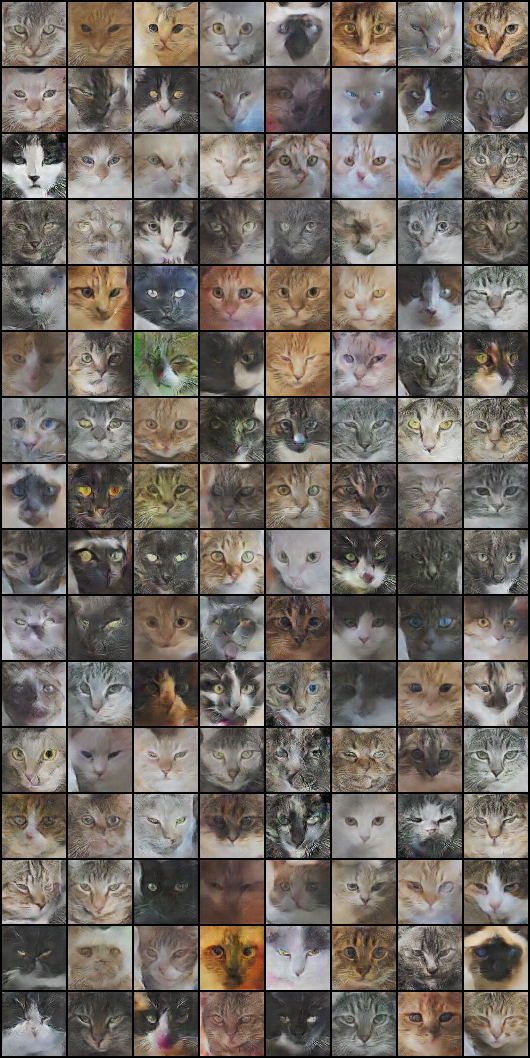

In [ ]:
from IPython.display import Image
Image(filename='/content/generated/generated-images-0100.png')
